Import Libraries

In [118]:
import os
import pickle
import gzip
import gdown
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


Loading Raw Data (Run this for training flow AND testing flow)

In [119]:

def load_cifar10_batch(file_path):
    """
    Load a single CIFAR-10 batch file.

    Parameters:
        file_path (str): Path to the CIFAR-10 batch file.

    Returns:
        tuple: (data, labels), where data is a NumPy array of shape [N, 3, 32, 32],
               and labels is a NumPy array of shape [N].
    """
    with open(file_path, 'rb') as file:
        batch = pickle.load(file, encoding='bytes')
        data = batch[b'data']
        labels = batch[b'labels']
        # Reshape to [N, 3, 32, 32] and normalize to [0, 1]
        data = data.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
        labels = np.array(labels)
    return data, labels

def load_cifar10_data(data_dir, batches):
    """
    Load CIFAR-10 data from multiple batch files.

    Parameters:
        data_dir (str): Directory containing CIFAR-10 batch files.
        batches (list): List of batch file names.

    Returns:
        tuple: (data, labels), where data is a NumPy array of shape [N, 3, 32, 32],
               and labels is a NumPy array of shape [N].
    """
    all_data = []
    all_labels = []
    for batch in batches:
        file_path = os.path.join(data_dir, batch)
        data, labels = load_cifar10_batch(file_path)
        all_data.append(data)
        all_labels.append(labels)
    # Concatenate all batches
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_data, all_labels
    # Define the paths to raw data

data_dir = "../Data/RawData/cifar-10-batches-py"
train_batches = [f"data_batch_{i}" for i in range(1, 6)]
test_batch = "test_batch"

# Load training data
X_train, y_train = load_cifar10_data(data_dir, train_batches)

# Load test data
X_test, y_test = load_cifar10_batch(os.path.join(data_dir, test_batch))

# Print shapes for verification
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Training data shape: (50000, 3, 32, 32), Training labels shape: (50000,)
Testing data shape: (10000, 3, 32, 32), Testing labels shape: (10000,)


Downloading and loading weights (Run this for testing flow ONLY)

In [120]:

def download_weights_only(model_configs):
    """
    Download weights for models if they do not already exist.

    Parameters:
    - model_configs: A list of dictionaries, each containing:
        - "name": Name of the model (for logging).
        - "file_id": Google Drive file ID for the weights.
        - "save_path": Path to save the weights file.
    """
    os.makedirs("Weights", exist_ok=True)

    for config in model_configs:
        save_path = config["save_path"]
        file_id = config["file_id"]

        if not os.path.exists(save_path):
            print(f"Downloading {config['name']} weights to {save_path}...")
            gdown.download(f"https://drive.google.com/uc?id={file_id}", save_path, quiet=False, fuzzy=True)
            print(f"Downloaded {config['name']} weights.")
        else:
            print(f"{config['name']} weights already exist at {save_path}.")

# Define model configurations for weights
model_configs = [
    {
        "name": "VGG11_weights.pth.gz",
        "file_id": "1j0TSqndlL92RFcLwkAc9MSS0L4tVjfkA",
        "save_path": os.path.join("Weights", "VGG11_weights.pth.gz")
    },
    {
        "name": "VGG11_ExtraConv_weights.pth.gz",
        "file_id": "1wUMh6QvkZso9-rtrw3h0Z6XFRa_6zmLE",
        "save_path": os.path.join("Weights", "VGG11_ExtraConv_weights.pth.gz")
    },
    {
        "name": "VGG11_LargeKernel_weights.pth.gz",
        "file_id": "1K5-8tlCEz0gWyPt4EeJkFG4ypZPHHkF_",
        "save_path": os.path.join("Weights", "VGG11_LargeKernel_weights.pth.gz")
    },
    {
        "name": "VGG11_RemoveConv_weights.pth.gz",
        "file_id": "1PiE1EyameQHHxTGAq5lLW70ULTO2Xkng",
        "save_path": os.path.join("Weights", "VGG11_RemoveConv_weights.pth.gz")
    },
    {
        "name": "VGG11_SmallerKernel_weights.pth.gz",
        "file_id": "1ecJRGZdX71FYHbzm1B23m6KZ7YI3S8mk",
        "save_path": os.path.join("Weights", "VGG11_SmallerKernel_weights.pth.gz")
    }
]

# Download weight files
download_weights_only(model_configs)
print("Weight files successfully imported.")

VGG11_weights.pth.gz weights already exist at Weights/VGG11_weights.pth.gz.
VGG11_ExtraConv_weights.pth.gz weights already exist at Weights/VGG11_ExtraConv_weights.pth.gz.
VGG11_LargeKernel_weights.pth.gz weights already exist at Weights/VGG11_LargeKernel_weights.pth.gz.
VGG11_RemoveConv_weights.pth.gz weights already exist at Weights/VGG11_RemoveConv_weights.pth.gz.
VGG11_SmallerKernel_weights.pth.gz weights already exist at Weights/VGG11_SmallerKernel_weights.pth.gz.
Weight files successfully imported.


Training and evaluation functions (Run this for training flow AND testing flow)

In [121]:
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    """
    Train the given model using the provided DataLoader, loss criterion, and optimizer.

    Parameters:
        model (torch.nn.Module): The model to train.
        train_loader (DataLoader): DataLoader for the training dataset.
        criterion (torch.nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        epochs (int): Number of training epochs.

    Returns:
        None
    """
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
    
            # Zero the gradients from the previous step
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

        # Print epoch loss
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

def evaluate_model(model, test_loader):
    """
    Evaluate the given model using the provided test DataLoader.

    Parameters:
        model (torch.nn.Module): The model to evaluate.
        test_loader (DataLoader): DataLoader for the test dataset.

    Returns:
        float: Accuracy of the model on the test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculations for evaluation
        for inputs, labels in test_loader:
            # Forward pass
            outputs = model(inputs)

            # Get predicted class indices
            _, predicted = outputs.max(1)

            # Update total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and print accuracy
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

Saving and loading .gz file (Run this for training flow AND testing flow)

In [122]:
# Define the save and load functions
def save_model_to_gz(model, file_path):
    """
    Save the model's state_dict to a compressed .gz file.
    
    Parameters:
    - model (torch.nn.Module): The PyTorch model to save.
    - file_path (str): The path where the compressed file will be saved, with a .gz extension.
    """
    # Open the specified file in write-binary mode with gzip compression
    with gzip.open(file_path, "wb") as f:
        # Save the model's state_dict (parameters) into the compressed file
        torch.save(model.state_dict(), f)
    # Print confirmation message
    print(f"Model weights saved to {file_path}")

def load_model_from_gz(model, file_path):
    """
    Load the model's state_dict from a compressed .gz file.
    
    Parameters:
    - model (torch.nn.Module): The PyTorch model instance to load weights into.
    - file_path (str): The path of the compressed file containing the saved state_dict.
    
    Returns:
    - model (torch.nn.Module): The model with the loaded weights.
    """
    # Open the specified file in read-binary mode with gzip decompression
    with gzip.open(file_path, "rb") as f:
        # Load the state_dict (parameters) from the compressed file and update the model
        model.load_state_dict(torch.load(f))
    # Print confirmation message
    print(f"Model weights loaded from {file_path}")
    # Return the model with loaded weights
    return model

 Define the base VGG11 architecture (Run this for training flow AND testing flow)


In [ ]:
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        # Define the feature extraction layers using a sequential container
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Convolution: Input 3 channels (RGB), output 64 channels
            nn.BatchNorm2d(64),                                   # Batch normalization to stabilize learning
            nn.ReLU(inplace=True),                               # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),               # Max pooling: Downsample the feature map by a factor of 2

            # Second convolutional block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Convolution: Input 64 channels, output 128 channels
            nn.BatchNorm2d(128),                                    # Batch normalization
            nn.ReLU(inplace=True),                                  # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),                  # Max pooling: Downsample by a factor of 2

            # Third convolutional block
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # Convolution: Input 128 channels, output 256 channels
            nn.BatchNorm2d(256),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # Second convolution in block: Input 256 channels, output 256 channels
            nn.BatchNorm2d(256),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Max pooling: Downsample by a factor of 2

            # Fourth convolutional block
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # Convolution: Input 256 channels, output 512 channels
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # Second convolution in block: Input 512 channels, output 512 channels
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Max pooling: Downsample by a factor of 2

            # Fifth convolutional block
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # Convolution: Input 512 channels, output 512 channels
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # Second convolution in block: Input 512 channels, output 512 channels
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2)                    # Max pooling: Downsample by a factor of 2
        )

        # Define the fully connected classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),         # Fully connected layer: Input 512 (flattened), output 4096
            nn.ReLU(inplace=True),        # Activation function (ReLU)
            nn.Dropout(0.5),              # Dropout: Prevent overfitting with 50% probability

            nn.Linear(4096, 4096),        # Fully connected layer: Input 4096, output 4096
            nn.ReLU(inplace=True),        # Activation function (ReLU)
            nn.Dropout(0.5),              # Dropout: Prevent overfitting with 50% probability

            nn.Linear(4096, 10)           # Fully connected layer: Input 4096, output 10 (number of classes)
        )

    def forward(self, x):
        # Forward pass through the feature extraction layers
        x = self.features(x)
        # Flatten the feature maps into a 1D vector for the fully connected layers
        x = torch.flatten(x, 1)
        # Forward pass through the classifier layers
        x = self.classifier(x)
        return x

Defining Stucture of Extra Convolutional Model (Run this for training flow AND testing flow) 

In [123]:
class VGG11_ExtraConv(nn.Module):
    def __init__(self):
        """
        Initialize the VGG11_ExtraConv model with an additional convolutional layer.
        """
        super(VGG11_ExtraConv, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Input: 3 channels (RGB), Output: 64 channels
            nn.BatchNorm2d(64),                                   # Batch normalization
            nn.ReLU(inplace=True),                               # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),               # Max pooling to downsample spatial dimensions by 2

            # Second convolutional block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Input: 64 channels, Output: 128 channels
            nn.BatchNorm2d(128),                                    # Batch normalization
            nn.ReLU(inplace=True),                                  # Activation function (ReLU)

            # Additional convolutional layer in the second block
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), # Extra convolution: Input: 128, Output: 128 channels
            nn.BatchNorm2d(128),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)

            nn.MaxPool2d(kernel_size=2, stride=2),                   # Max pooling to downsample by 2

            # Third convolutional block
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # Input: 128 channels, Output: 256 channels
            nn.BatchNorm2d(256),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # Second convolution: Input: 256, Output: 256 channels
            nn.BatchNorm2d(256),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Max pooling to downsample by 2

            # Fourth convolutional block
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # Input: 256 channels, Output: 512 channels
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # Second convolution: Input: 512, Output: 512 channels
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Max pooling to downsample by 2

            # Fifth convolutional block
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # Input: 512 channels, Output: 512 channels
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), # Second convolution: Input: 512, Output: 512 channels
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2)                    # Max pooling to downsample by 2
        )

        # Fully connected classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),         # Fully connected layer: Input 512 (flattened), Output 4096
            nn.ReLU(inplace=True),        # Activation function (ReLU)
            nn.Dropout(0.5),              # Dropout to reduce overfitting (50% probability)

            nn.Linear(4096, 4096),        # Fully connected layer: Input 4096, Output 4096
            nn.ReLU(inplace=True),        # Activation function (ReLU)
            nn.Dropout(0.5),              # Dropout to reduce overfitting (50% probability)

            nn.Linear(4096, 10)           # Fully connected layer: Input 4096, Output 10 (number of classes)
        )

    def forward(self, x):
        """
        Define the forward pass of the model.
        
        Parameters:
        - x (torch.Tensor): Input tensor with shape (batch_size, channels, height, width).
        
        Returns:
        - x (torch.Tensor): Output predictions with shape (batch_size, num_classes).
        """
        x = self.features(x)              # Pass input through feature extraction layers
        x = torch.flatten(x, 1)           # Flatten feature maps to prepare for the fully connected layers
        x = self.classifier(x)            # Pass through the classifier
        return x

Defining Structure of Model with Larger Kernel Size (5x5)(Run this for training flow AND testing flow)

In [124]:
import torch
import torch.nn as nn

class VGG11_LargeKernel(nn.Module):
    def __init__(self):
        """
        Initialize the VGG11_LargeKernel model with convolutional layers using larger kernels.
        """
        super(VGG11_LargeKernel, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=2),  # Input: 3 channels, Output: 64 channels, Larger 5x5 kernel
            nn.BatchNorm2d(64),                                   # Batch normalization for stabilized learning
            nn.ReLU(inplace=True),                               # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),               # Max pooling to downsample spatial dimensions by 2

            # Second convolutional block
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2), # Input: 64 channels, Output: 128 channels, Larger 5x5 kernel
            nn.BatchNorm2d(128),                                    # Batch normalization
            nn.ReLU(inplace=True),                                  # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),                  # Max pooling to downsample spatial dimensions by 2

            # Third convolutional block
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2), # Input: 128 channels, Output: 256 channels, Larger 5x5 kernel
            nn.BatchNorm2d(256),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)

            nn.Conv2d(256, 256, kernel_size=5, stride=1, padding=2), # Second convolution: Input: 256, Output: 256 channels, Larger 5x5 kernel
            nn.BatchNorm2d(256),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Max pooling to downsample spatial dimensions by 2

            # Fourth convolutional block
            nn.Conv2d(256, 512, kernel_size=5, stride=1, padding=2), # Input: 256 channels, Output: 512 channels, Larger 5x5 kernel
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)

            nn.Conv2d(512, 512, kernel_size=5, stride=1, padding=2), # Second convolution: Input: 512, Output: 512 channels, Larger 5x5 kernel
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Max pooling to downsample spatial dimensions by 2

            # Fifth convolutional block
            nn.Conv2d(512, 512, kernel_size=5, stride=1, padding=2), # Input: 512 channels, Output: 512 channels, Larger 5x5 kernel
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)

            nn.Conv2d(512, 512, kernel_size=5, stride=1, padding=2), # Second convolution: Input: 512, Output: 512 channels, Larger 5x5 kernel
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2)                    # Max pooling to downsample spatial dimensions by 2
        )

        # Fully connected classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),         # Fully connected layer: Input 512 (flattened), Output 4096
            nn.ReLU(inplace=True),        # Activation function (ReLU)
            nn.Dropout(0.5),              # Dropout to reduce overfitting (50% probability)

            nn.Linear(4096, 4096),        # Fully connected layer: Input 4096, Output 4096
            nn.ReLU(inplace=True),        # Activation function (ReLU)
            nn.Dropout(0.5),              # Dropout to reduce overfitting (50% probability)

            nn.Linear(4096, 10)           # Fully connected layer: Input 4096, Output 10 (number of classes)
        )

    def forward(self, x):
        """
        Define the forward pass of the model.
        
        Parameters:
        - x (torch.Tensor): Input tensor with shape (batch_size, channels, height, width).
        
        Returns:
        - x (torch.Tensor): Output predictions with shape (batch_size, num_classes).
        """
        x = self.features(x)              # Pass input through feature extraction layers
        x = torch.flatten(x, 1)           # Flatten feature maps to prepare for the fully connected layers
        x = self.classifier(x)            # Pass through the classifier
        return x

Defining Structure with a removed Convolutional Layer (Run this for training flow AND testing flow)

In [125]:

class VGG11_RemoveConv(nn.Module):
    def __init__(self):
        """
        Initialize the VGG11_RemoveConv model with one fewer convolutional layer.
        """
        super(VGG11_RemoveConv, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # Input: 3 channels (RGB), Output: 64 channels
            nn.BatchNorm2d(64),                                   # Batch normalization
            nn.ReLU(inplace=True),                               # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),               # Max pooling to downsample spatial dimensions by 2

            # Second convolutional block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Input: 64 channels, Output: 128 channels
            nn.BatchNorm2d(128),                                    # Batch normalization
            nn.ReLU(inplace=True),                                  # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),                  # Max pooling to downsample spatial dimensions by 2

            # Third convolutional block (reduced by one layer)
            # Removed an extra convolution here to simplify the model
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # Input: 128 channels, Output: 256 channels
            nn.BatchNorm2d(256),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Max pooling to downsample spatial dimensions by 2

            # Fourth convolutional block
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), # Input: 256 channels, Output: 512 channels
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2)                    # Max pooling to downsample spatial dimensions by 2
        )

        # Fully connected classifier layers
        # Adjusted input size for the first fully connected layer due to fewer convolutional layers
        self.classifier = nn.Sequential(
            nn.Linear(2048, 4096),         # Fully connected layer: Input 2048 (flattened), Output 4096
            nn.ReLU(inplace=True),        # Activation function (ReLU)
            nn.Dropout(0.5),              # Dropout to reduce overfitting (50% probability)

            nn.Linear(4096, 4096),        # Fully connected layer: Input 4096, Output 4096
            nn.ReLU(inplace=True),        # Activation function (ReLU)
            nn.Dropout(0.5),              # Dropout to reduce overfitting (50% probability)

            nn.Linear(4096, 10)           # Fully connected layer: Input 4096, Output 10 (number of classes)
        )

    def forward(self, x):
        """
        Define the forward pass of the model.
        
        Parameters:
        - x (torch.Tensor): Input tensor with shape (batch_size, channels, height, width).
        
        Returns:
        - x (torch.Tensor): Output predictions with shape (batch_size, num_classes).
        """
        x = self.features(x)              # Pass input through feature extraction layers
        x = torch.flatten(x, 1)           # Flatten feature maps to prepare for the fully connected layers
        x = self.classifier(x)            # Pass through the classifier
        return x

Defining model with a smaller kernel size (2x2)(Run this for training flow AND testing flow)

In [126]:
import torch
import torch.nn as nn

class VGG11_SmallerKernel(nn.Module):
    def __init__(self):
        """
        Initialize the VGG11_SmallerKernel model using smaller convolutional kernels (2x2).
        """
        super(VGG11_SmallerKernel, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 64, kernel_size=2, stride=1, padding=1),  # Smaller 2x2 kernel, Input: 3 channels, Output: 64 channels
            nn.BatchNorm2d(64),                                   # Batch normalization
            nn.ReLU(inplace=True),                               # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),               # Max pooling to downsample spatial dimensions by 2

            # Second convolutional block
            nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=1), # Smaller 2x2 kernel, Input: 64 channels, Output: 128 channels
            nn.BatchNorm2d(128),                                    # Batch normalization
            nn.ReLU(inplace=True),                                  # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),                  # Max pooling to downsample spatial dimensions by 2

            # Third convolutional block
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1), # Smaller 2x2 kernel, Input: 128 channels, Output: 256 channels
            nn.BatchNorm2d(256),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)

            nn.Conv2d(256, 256, kernel_size=2, stride=1, padding=1), # Second convolution with 2x2 kernel
            nn.BatchNorm2d(256),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Max pooling to downsample spatial dimensions by 2

            # Fourth convolutional block
            nn.Conv2d(256, 512, kernel_size=2, stride=1, padding=1), # Smaller 2x2 kernel, Input: 256 channels, Output: 512 channels
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)

            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=1), # Second convolution with 2x2 kernel
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2),                   # Max pooling to downsample spatial dimensions by 2

            # Fifth convolutional block
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=1), # Smaller 2x2 kernel, Input: 512 channels, Output: 512 channels
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)

            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=1), # Second convolution with 2x2 kernel
            nn.BatchNorm2d(512),                                     # Batch normalization
            nn.ReLU(inplace=True),                                   # Activation function (ReLU)
            nn.MaxPool2d(kernel_size=2, stride=2)                    # Max pooling to downsample spatial dimensions by 2
        )
        
        # Fully connected classifier layers
        # Adjusted input size for the first Linear layer based on output dimensions from features
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),  # Input size is the flattened output from features
            nn.ReLU(inplace=True),        # Activation function (ReLU)
            nn.Dropout(0.5),              # Dropout to reduce overfitting (50% probability)

            nn.Linear(4096, 4096),        # Fully connected layer: Input 4096, Output 4096
            nn.ReLU(inplace=True),        # Activation function (ReLU)
            nn.Dropout(0.5),              # Dropout to reduce overfitting (50% probability)

            nn.Linear(4096, 10)           # Fully connected layer: Input 4096, Output 10 (number of classes)
        )

    def forward(self, x):
        """
        Define the forward pass of the model.
        
        Parameters:
        - x (torch.Tensor): Input tensor with shape (batch_size, channels, height, width).
        
        Returns:
        - x (torch.Tensor): Output predictions with shape (batch_size, num_classes).
        """
        x = self.features(x)              # Pass input through feature extraction layers

        # Debugging: Print the shape of the feature output once during the first forward pass
        if not hasattr(self, "debug_printed"):
            print(f"Shape after features: {x.shape}")
            self.debug_printed = True  # Flag to prevent repeated printing

        x = torch.flatten(x, 1)           # Flatten feature maps to prepare for the fully connected layers
        x = self.classifier(x)            # Pass through the classifier
        return x

-------Training Each Model, Skip this if you do not want to train, you can simply use the saved weights to test--------

Training Base VGG11 Model (Training flow ONLY)

In [ ]:
# Initialize the model, optimizer, and loss function
base_model = VGG11()
optimizer = optim.SGD(base_model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss() # Cross-entropy loss for classification

# Train the model
train_model(base_model, train_loader, criterion, optimizer, epochs=50)

# Save the model weights to a .gz file
weights_dir = "Weights"
os.makedirs(weights_dir, exist_ok=True)
vgg11_weights_path = os.path.join(weights_dir, "VGG11_weights.pth.gz")
save_model_to_gz(base_model, vgg11_weights_path)

Train the model with the extra convolutional layer (Training flow ONLY)

In [ ]:
# Define the model and optimizer
extra_conv_model = VGG11_ExtraConv()
optimizer = optim.SGD(extra_conv_model.parameters(), lr=0.01, momentum=0.9)

# Train the model
print("\nTraining Modified Model with Extra Conv Layer...")
train_model(extra_conv_model, train_loader, criterion, optimizer, epochs=50)

# Save the model weights using the save_model_to_gz function
weights_dir = "Weights"
os.makedirs(weights_dir, exist_ok=True)
extra_model_weights_path = os.path.join(weights_dir, "VGG11_ExtraConv_weights.pth.gz")
save_model_to_gz(extra_conv_model, extra_model_weights_path)

print(f"Compressed model weights saved to {extra_model_weights_path}")


Training Modified Model with Extra Conv Layer...
Epoch 1/50, Loss: 1.3006
Epoch 2/50, Loss: 0.8073
Epoch 3/50, Loss: 0.6035
Epoch 4/50, Loss: 0.4712
Epoch 5/50, Loss: 0.3691
Epoch 6/50, Loss: 0.2877
Epoch 7/50, Loss: 0.2260
Epoch 8/50, Loss: 0.1745
Epoch 9/50, Loss: 0.1438
Epoch 10/50, Loss: 0.1104
Epoch 11/50, Loss: 0.0848
Epoch 12/50, Loss: 0.0775
Epoch 13/50, Loss: 0.0600
Epoch 14/50, Loss: 0.0590
Epoch 15/50, Loss: 0.0440
Epoch 16/50, Loss: 0.0399
Epoch 17/50, Loss: 0.0288
Epoch 18/50, Loss: 0.0312
Epoch 19/50, Loss: 0.0322
Epoch 20/50, Loss: 0.0243
Epoch 21/50, Loss: 0.0274
Epoch 22/50, Loss: 0.0219
Epoch 23/50, Loss: 0.0226
Epoch 24/50, Loss: 0.0139
Epoch 25/50, Loss: 0.0200
Epoch 26/50, Loss: 0.0180
Epoch 27/50, Loss: 0.0116
Epoch 28/50, Loss: 0.0085
Epoch 29/50, Loss: 0.0111
Epoch 30/50, Loss: 0.0103
Epoch 31/50, Loss: 0.0181
Epoch 32/50, Loss: 0.0099
Epoch 33/50, Loss: 0.0103
Epoch 34/50, Loss: 0.0088
Epoch 35/50, Loss: 0.0067
Epoch 36/50, Loss: 0.0078
Epoch 37/50, Loss: 0.00

Training the model with a larger kernel size (Training flow ONLY)

In [ ]:
# Define the model and optimizer
large_kernel_model = VGG11_LargeKernel()
optimizer = optim.SGD(large_kernel_model.parameters(), lr=0.01, momentum=0.9)

# Train the model
print("\nTraining Model with Larger Kernels...")
train_model(large_kernel_model, train_loader, criterion, optimizer, epochs=50)

# Save the model weights using gzip
weights_dir = "Weights"
os.makedirs(weights_dir, exist_ok=True)
large_kernel_weights_path = os.path.join(weights_dir, "VGG11_LargeKernel_weights.pth.gz")
save_model_to_gz(large_kernel_model, large_kernel_weights_path)

print(f"Larger kernel model weights saved to {large_kernel_weights_path}")


Training Model with Larger Kernels...
Epoch 1/50, Loss: 1.4187
Epoch 2/50, Loss: 0.9567
Epoch 3/50, Loss: 0.7406
Epoch 4/50, Loss: 0.6064
Epoch 5/50, Loss: 0.5031
Epoch 6/50, Loss: 0.4163
Epoch 7/50, Loss: 0.3310
Epoch 8/50, Loss: 0.2686
Epoch 9/50, Loss: 0.2230
Epoch 10/50, Loss: 0.1749
Epoch 11/50, Loss: 0.1369
Epoch 12/50, Loss: 0.1167
Epoch 13/50, Loss: 0.0953
Epoch 14/50, Loss: 0.0802
Epoch 15/50, Loss: 0.0693
Epoch 16/50, Loss: 0.0551
Epoch 17/50, Loss: 0.0505
Epoch 18/50, Loss: 0.0427
Epoch 19/50, Loss: 0.0425
Epoch 20/50, Loss: 0.0290
Epoch 21/50, Loss: 0.0361
Epoch 22/50, Loss: 0.0258
Epoch 23/50, Loss: 0.0249
Epoch 24/50, Loss: 0.0223
Epoch 25/50, Loss: 0.0171
Epoch 26/50, Loss: 0.0190
Epoch 27/50, Loss: 0.0205
Epoch 28/50, Loss: 0.0167
Epoch 29/50, Loss: 0.0169
Epoch 30/50, Loss: 0.0110
Epoch 31/50, Loss: 0.0122
Epoch 32/50, Loss: 0.0145
Epoch 33/50, Loss: 0.0104
Epoch 34/50, Loss: 0.0112
Epoch 35/50, Loss: 0.0085
Epoch 36/50, Loss: 0.0109
Epoch 37/50, Loss: 0.0087
Epoch 38

Training the model with a removed convolutional layer (Training flow ONLY)

In [ ]:
# Define the model and optimizer
remove_conv_model = VGG11_RemoveConv()
optimizer = optim.SGD(remove_conv_model.parameters(), lr=0.01, momentum=0.9)

# Train the model
print("\nTraining Model with Removed Conv Layer...")
train_model(remove_conv_model, train_loader, criterion, optimizer, epochs=50)

# Save the model weights using a .gz file
weights_dir = "Weights"
os.makedirs(weights_dir, exist_ok=True)
remove_conv_weights_path = os.path.join(weights_dir, "VGG11_RemoveConv_weights.pth.gz")

# Save the weights in a compressed .gz file
with gzip.open(remove_conv_weights_path, "wb") as f:
    torch.save(remove_conv_model.state_dict(), f)
print(f"Model with removed conv layer weights saved to {remove_conv_weights_path}")


Training Model with Removed Conv Layer...
Epoch 1/50, Loss: 1.3423
Epoch 2/50, Loss: 0.9146
Epoch 3/50, Loss: 0.7423
Epoch 4/50, Loss: 0.6284
Epoch 5/50, Loss: 0.5385
Epoch 6/50, Loss: 0.4633
Epoch 7/50, Loss: 0.3972
Epoch 8/50, Loss: 0.3310
Epoch 9/50, Loss: 0.2807
Epoch 10/50, Loss: 0.2373
Epoch 11/50, Loss: 0.1999
Epoch 12/50, Loss: 0.1790
Epoch 13/50, Loss: 0.1470
Epoch 14/50, Loss: 0.1225
Epoch 15/50, Loss: 0.1101
Epoch 16/50, Loss: 0.0907
Epoch 17/50, Loss: 0.0825
Epoch 18/50, Loss: 0.0661
Epoch 19/50, Loss: 0.0656
Epoch 20/50, Loss: 0.0504
Epoch 21/50, Loss: 0.0447
Epoch 22/50, Loss: 0.0432
Epoch 23/50, Loss: 0.0409
Epoch 24/50, Loss: 0.0409
Epoch 25/50, Loss: 0.0390
Epoch 26/50, Loss: 0.0273
Epoch 27/50, Loss: 0.0294
Epoch 28/50, Loss: 0.0260
Epoch 29/50, Loss: 0.0211
Epoch 30/50, Loss: 0.0216
Epoch 31/50, Loss: 0.0279
Epoch 32/50, Loss: 0.0201
Epoch 33/50, Loss: 0.0187
Epoch 34/50, Loss: 0.0161
Epoch 35/50, Loss: 0.0190
Epoch 36/50, Loss: 0.0170
Epoch 37/50, Loss: 0.0103
Epoc

Training the model with a smaller kernel size (2x2)(Training flow ONLY)

In [ ]:
# Initialize the model
model = VGG11_SmallerKernel()

# Define the optimizer and criterion
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Train the model
print("\nTraining Model with Smaller Kernel...")
train_model(model, train_loader, criterion, optimizer, epochs=50)

# Save the model weights using gzip
weights_dir = "Weights"
os.makedirs(weights_dir, exist_ok=True)

def save_model_to_gz(model, filename):
    with gzip.open(filename, "wb") as f:
        torch.save(model.state_dict(), f)
    print(f"Model weights saved to {filename}")

# Save the trained weights
weights_path = os.path.join(weights_dir, "VGG11_SmallerKernel_weights.pth.gz")
save_model_to_gz(model, weights_path)


Training Model with Smaller Kernel...
Shape after features: torch.Size([128, 512, 2, 2])
Epoch 1/50, Loss: 1.3916
Epoch 2/50, Loss: 0.9191
Epoch 3/50, Loss: 0.7120
Epoch 4/50, Loss: 0.5674
Epoch 5/50, Loss: 0.4619
Epoch 6/50, Loss: 0.3753
Epoch 7/50, Loss: 0.2972
Epoch 8/50, Loss: 0.2445
Epoch 9/50, Loss: 0.1899
Epoch 10/50, Loss: 0.1532
Epoch 11/50, Loss: 0.1246
Epoch 12/50, Loss: 0.1088
Epoch 13/50, Loss: 0.0960
Epoch 14/50, Loss: 0.0693
Epoch 15/50, Loss: 0.0698
Epoch 16/50, Loss: 0.0547
Epoch 17/50, Loss: 0.0491
Epoch 18/50, Loss: 0.0481
Epoch 19/50, Loss: 0.0392
Epoch 20/50, Loss: 0.0307
Epoch 21/50, Loss: 0.0320
Epoch 22/50, Loss: 0.0267
Epoch 23/50, Loss: 0.0232
Epoch 24/50, Loss: 0.0251
Epoch 25/50, Loss: 0.0271
Epoch 26/50, Loss: 0.0143
Epoch 27/50, Loss: 0.0209
Epoch 28/50, Loss: 0.0198
Epoch 29/50, Loss: 0.0183
Epoch 30/50, Loss: 0.0123
Epoch 31/50, Loss: 0.0156
Epoch 32/50, Loss: 0.0140
Epoch 33/50, Loss: 0.0105
Epoch 34/50, Loss: 0.0124
Epoch 35/50, Loss: 0.0158
Epoch 36/

--------- Training Is Finished, From now it will only be testing and key metrics generation---------------

Loading and Evaluating of the Base VGG11 Model (Run this for training flow AND testing flow)

/var/folders/k3/98zc9v0x1j7f3xfskw_mln740000gn/T/ipykernel_85836/411269495.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_model.load_state_dict(torch.load(f))


Base model weights loaded from Weights/VGG11_weights.pth.gz


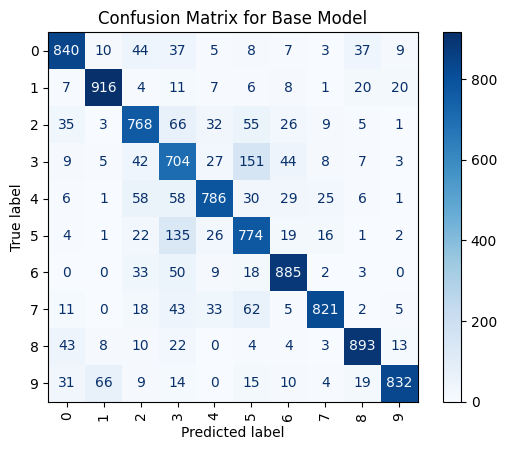

Base Model Test Accuracy: 82.19%


In [128]:
# Define paths and model configuration
weights_dir = "Weights"
os.makedirs(weights_dir, exist_ok=True)
vgg11_weights_path = os.path.join(weights_dir, "VGG11_weights.pth.gz")  # Path to already downloaded weights file

# Check if the weights file exists
if not os.path.exists(vgg11_weights_path):
    raise FileNotFoundError(f"Weight file not found at {vgg11_weights_path}. Please ensure it has been downloaded.")

# Reload the model
base_model = VGG11()

# Load the saved weights from the .gz file
with gzip.open(vgg11_weights_path, "rb") as f:  # Use gzip to decompress
    base_model.load_state_dict(torch.load(f))
print(f"Base model weights loaded from {vgg11_weights_path}")

# Evaluate the loaded model and generate confusion matrix
base_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = base_model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
classes = [str(i) for i in range(10)]  # Use numeric class names or replace with actual CIFAR-10 labels
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.title("Confusion Matrix for Base Model")
plt.show()

# Calculate and print accuracy
correct = sum([1 if t == p else 0 for t, p in zip(y_true, y_pred)])
total = len(y_true)
base_accuracy = 100 * correct / total
print(f"Base Model Test Accuracy: {base_accuracy:.2f}%")

Evaluate and load model with extra convolutional layer (Run this for training flow AND testing flow)

/var/folders/k3/98zc9v0x1j7f3xfskw_mln740000gn/T/ipykernel_85836/1578835427.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  extra_conv_model.load_state_dict(torch.load(

Modified model weights loaded from Weights/VGG11_ExtraConv_weights.pth.gz


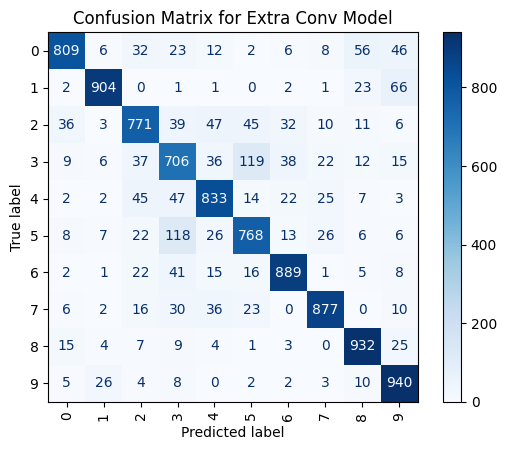

Modified Model Test Accuracy: 84.29%


: 

In [ ]:
# Define paths and model configuration
weights_dir = "Weights"
os.makedirs(weights_dir, exist_ok=True)
extra_model_weights_path = os.path.join(weights_dir, "VGG11_ExtraConv_weights.pth.gz")  # Path to already downloaded weights file

# Check if the weights file exists
if not os.path.exists(extra_model_weights_path):
    raise FileNotFoundError(f"Weight file not found at {extra_model_weights_path}. Please ensure it has been downloaded.")

# Reload the model
extra_conv_model = VGG11_ExtraConv()

# Load the saved weights from the .gz file
with gzip.open(extra_model_weights_path, "rb") as f:  # Use gzip to decompress
    extra_conv_model.load_state_dict(torch.load(f))
print(f"Modified model weights loaded from {extra_model_weights_path}")

# Evaluate the loaded model and generate confusion matrix
extra_conv_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = extra_conv_model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
classes = [str(i) for i in range(10)]  # Use numeric class names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.title("Confusion Matrix for Extra Conv Model")
plt.show()

# Calculate and print accuracy
correct = sum([1 if t == p else 0 for t, p in zip(y_true, y_pred)])
total = len(y_true)
extra_accuracy = 100 * correct / total
print(f"Modified Model Test Accuracy: {extra_accuracy:.2f}%")

Loading and Evaluating model with a larger kernel size (5x5) (Run this for training flow AND testing flow)

/var/folders/k3/98zc9v0x1j7f3xfskw_mln740000gn/T/ipykernel_85836/923216499.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  large_kernel_model.load_state_dict(torch.load

Large Kernel Model weights loaded from Weights/VGG11_LargeKernel_weights.pth.gz


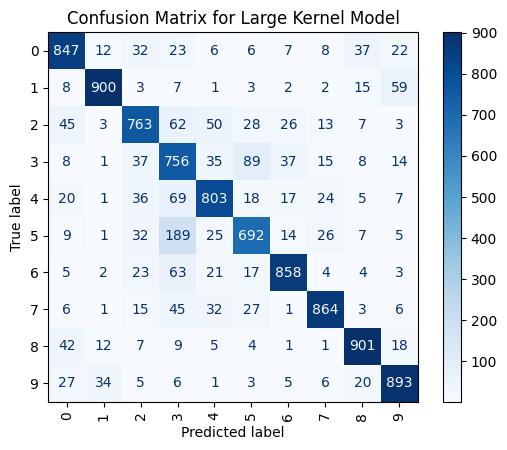

Large Kernel Model Test Accuracy: 82.77%


: 

In [ ]:
# Define paths and model configuration
weights_dir = "Weights"
os.makedirs(weights_dir, exist_ok=True)
large_kernel_weights_path = os.path.join(weights_dir, "VGG11_LargeKernel_weights.pth.gz")  # Path to already downloaded weights file

# Check if the weights file exists
if not os.path.exists(large_kernel_weights_path):
    raise FileNotFoundError(f"Weight file not found at {large_kernel_weights_path}. Please ensure it has been downloaded.")

# Reload the model
large_kernel_model = VGG11_LargeKernel()

# Load the weights
with gzip.open(large_kernel_weights_path, "rb") as f:
    large_kernel_model.load_state_dict(torch.load(f))
print(f"Large Kernel Model weights loaded from {large_kernel_weights_path}")

# Evaluate the loaded model and generate confusion matrix
large_kernel_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = large_kernel_model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
classes = [str(i) for i in range(10)]  # Use numeric class names or replace with actual CIFAR-10 labels
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.title("Confusion Matrix for Large Kernel Model")
plt.show()

# Calculate and print accuracy
correct = sum([1 if t == p else 0 for t, p in zip(y_true, y_pred)])
total = len(y_true)
large_kernel_accuracy = 100 * correct / total
print(f"Large Kernel Model Test Accuracy: {large_kernel_accuracy:.2f}%")

Evaluating and loading model with a removed convolutional layer (Run this for training flow AND testing flow)

/var/folders/k3/98zc9v0x1j7f3xfskw_mln740000gn/T/ipykernel_85836/232906698.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  remove_conv_model.load_state_dict(torch.load(

Model with removed conv layer weights loaded from Weights/VGG11_RemoveConv_weights.pth.gz


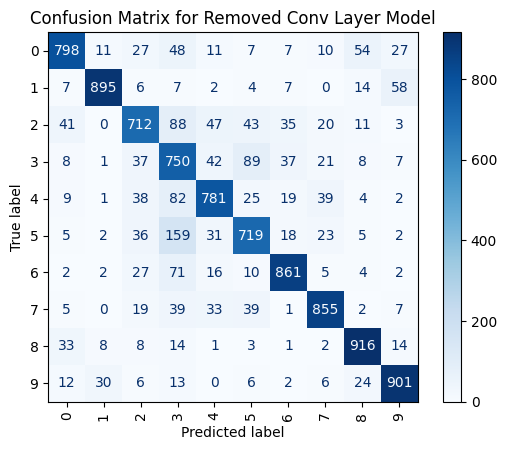

Model with Removed Conv Layer Test Accuracy: 81.88%


: 

In [ ]:
# Define paths and model configuration
weights_dir = "Weights"
os.makedirs(weights_dir, exist_ok=True)
remove_conv_weights_path = os.path.join(weights_dir, "VGG11_RemoveConv_weights.pth.gz")  # Path to already downloaded weights file

# Check if the weights file exists
if not os.path.exists(remove_conv_weights_path):
    raise FileNotFoundError(f"Weight file not found at {remove_conv_weights_path}. Please ensure it has been downloaded.")

# Reload the model
remove_conv_model = VGG11_RemoveConv()

# Load the weights
with gzip.open(remove_conv_weights_path, "rb") as f:
    remove_conv_model.load_state_dict(torch.load(f))
print(f"Model with removed conv layer weights loaded from {remove_conv_weights_path}")

# Evaluate the loaded model and generate confusion matrix
remove_conv_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = remove_conv_model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
classes = [str(i) for i in range(10)]  
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.title("Confusion Matrix for Removed Conv Layer Model")
plt.show()

# Calculate and print accuracy
correct = sum([1 if t == p else 0 for t, p in zip(y_true, y_pred)])
total = len(y_true)
remove_conv_accuracy = 100 * correct / total
print(f"Model with Removed Conv Layer Test Accuracy: {remove_conv_accuracy:.2f}%")

Evaluating and loading model with a smaller kernel size (2x2) (Run this for training flow AND testing flow)

/var/folders/k3/98zc9v0x1j7f3xfskw_mln740000gn/T/ipykernel_85836/63756118.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  smaller_kernel_model.load_state_dict(torch.loa

Model weights loaded from Weights/VGG11_SmallerKernel_weights.pth.gz
Shape after features: torch.Size([128, 512, 2, 2])


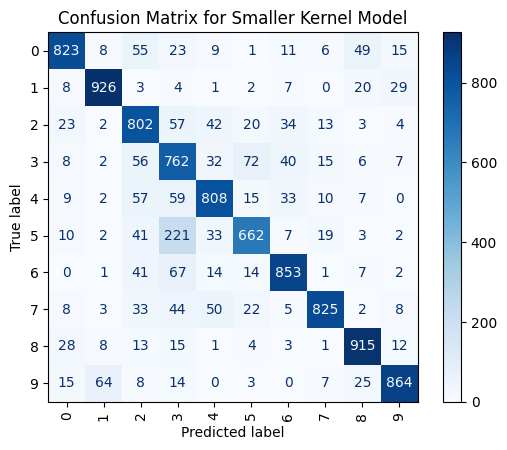

Model with Smaller Kernel Size Test Accuracy: 82.40%


: 

In [ ]:
import os
import gzip
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define paths and model configuration
weights_dir = "Weights"
os.makedirs(weights_dir, exist_ok=True)
smaller_kernel_weights_path = os.path.join(weights_dir, "VGG11_SmallerKernel_weights.pth.gz")  # Path to already downloaded weights file

# Check if the weights file exists
if not os.path.exists(smaller_kernel_weights_path):
    raise FileNotFoundError(f"Weight file not found at {smaller_kernel_weights_path}. Please ensure it has been downloaded.")

# Reload the model
smaller_kernel_model = VGG11_SmallerKernel()

# Load the compressed weights
with gzip.open(smaller_kernel_weights_path, "rb") as f:
    smaller_kernel_model.load_state_dict(torch.load(f))
print(f"Model weights loaded from {smaller_kernel_weights_path}")

# Evaluate the loaded model and generate confusion matrix
smaller_kernel_model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = smaller_kernel_model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Generate confusion matrix
classes = [str(i) for i in range(10)]  # Use numeric class names or replace with actual CIFAR-10 labels
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.title("Confusion Matrix for Smaller Kernel Model")
plt.show()

# Calculate and print accuracy
correct = sum([1 if t == p else 0 for t, p in zip(y_true, y_pred)])
total = len(y_true)
smaller_kernel_accuracy = 100 * correct / total
print(f"Model with Smaller Kernel Size Test Accuracy: {smaller_kernel_accuracy:.2f}%")

Result Analysis (Run this for training flow AND testing flow)

In [ ]:
# Function to evaluate model performance and calculate metrics only
def evaluate_model_with_metrics(model, test_loader, classes):
   
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate metrics
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    metrics = {
        "Accuracy": report["accuracy"],
        "Precision": [report[str(i)]["precision"] for i in range(len(classes))],
        "Recall": [report[str(i)]["recall"] for i in range(len(classes))],
        "F1-Score": [report[str(i)]["f1-score"] for i in range(len(classes))],
    }
    return metrics


# CIFAR-10 class labels as numbers
classes = [str(i) for i in range(10)]

# Evaluate all models and collect metrics
print("\nEvaluating Base Model...")
base_metrics = evaluate_model_with_metrics(base_model, test_loader, classes)

print("\nEvaluating Extra Conv Layer Model...")
extra_conv_metrics = evaluate_model_with_metrics(extra_conv_model, test_loader, classes)

print("\nEvaluating Larger Kernel Model...")
large_kernel_metrics = evaluate_model_with_metrics(large_kernel_model, test_loader, classes)

print("\nEvaluating Removed Conv Layer Model...")
remove_conv_metrics = evaluate_model_with_metrics(remove_conv_model, test_loader, classes)

print("\nEvaluating Smaller Kernel Model...")
smaller_kernel_metrics = evaluate_model_with_metrics(smaller_kernel_model, test_loader, classes)

# Summarize results in a table
results_summary = pd.DataFrame({
    "Model": [
        "Base VGG11",
        "Extra Conv Layer",
        "Larger Kernel",
        "Removed Conv Layer",
        "Smaller Kernels"
    ],
    "Accuracy": [
        base_metrics["Accuracy"],
        extra_conv_metrics["Accuracy"],
        large_kernel_metrics["Accuracy"],
        remove_conv_metrics["Accuracy"],
        smaller_kernel_metrics["Accuracy"]
    ],
    "Precision (avg)": [
        np.mean(base_metrics["Precision"]),
        np.mean(extra_conv_metrics["Precision"]),
        np.mean(large_kernel_metrics["Precision"]),
        np.mean(remove_conv_metrics["Precision"]),
        np.mean(smaller_kernel_metrics["Precision"])
    ],
    "Recall (avg)": [
        np.mean(base_metrics["Recall"]),
        np.mean(extra_conv_metrics["Recall"]),
        np.mean(large_kernel_metrics["Recall"]),
        np.mean(remove_conv_metrics["Recall"]),
        np.mean(smaller_kernel_metrics["Recall"])
    ],
    "F1-Score (avg)": [
        np.mean(base_metrics["F1-Score"]),
        np.mean(extra_conv_metrics["F1-Score"]),
        np.mean(large_kernel_metrics["F1-Score"]),
        np.mean(remove_conv_metrics["F1-Score"]),
        np.mean(smaller_kernel_metrics["F1-Score"])
    ]
})

# Display the summary table
print("\nSummary of Model Performance:")
print(results_summary)


Evaluating Base Model...

Evaluating Extra Conv Layer Model...

Evaluating Larger Kernel Model...

Evaluating Removed Conv Layer Model...

Evaluating Smaller Kernel Model...

Summary of Model Performance:
                Model  Accuracy  Precision (avg)  Recall (avg)  F1-Score (avg)
0          Base VGG11    0.8219         0.828944        0.8219        0.824125
1    Extra Conv Layer    0.8429         0.844071        0.8429        0.842722
2       Larger Kernel    0.8277         0.832499        0.8277        0.828951
3  Removed Conv Layer    0.8188         0.825073        0.8188        0.820488
4     Smaller Kernels    0.8240         0.832350        0.8240        0.825786


: 